In [1]:
import glob
import numpy as np

from astropy.io import fits
from astropy.table import Table

from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
def spectrum_coadd(exps,rest_frame_shift=False):
       
    fls = [];
    ivars = [];
    
    for nn in np.arange(len(exps))[0:]:
        exp = exps[nn]
        
        wl = exp.header['CRVAL1'] + exp.header['CD1_1'] * np.arange(exp.data.shape[2])
        fl = exp.data[0,0,:]
        ivar = exp.data[3,0,:]**-2
    
        if rest_frame_shift:
            fl, ivar = doppler_shift(wl,fl,ivar)
        
        fls.append(fl)
        ivars.append(ivar)

    ivars = np.array(ivars)
    mask = ivars == 0
    ivars[mask] = 1 # dummy
    variances = 1 / ivars
    variance = np.sum(variances, axis = 0) / len(variances)**2
    ivar = 1 / variance

    fl = np.median(fls, axis = 0)
    smask = (mask).all(axis = 0)
    ivar[smask] = 1e-6
    
    return wl, fl, ivar

In [3]:
ms = glob.glob('MS/CDAFB*')

In [4]:
names = []

for file in ms:
    temp = fits.open(file)
    names.append(temp[0].header['OBJNAME'])
names = list(set(names))

In [5]:
from tqdm import tqdm

targets = {}
ms_coords = {}

for name in names:
    targets[name] = []
    
for name in names:
    for file in tqdm(ms):
        temp = fits.open(file)
        
        if temp[0].header['OBJNAME'] == name:
            ms_coords[name] = (temp[0].header['RA'], temp[0].header['DEC'])
            targets[name].append(temp[0])

100%|██████████| 10/10 [00:00<00:00, 767.23it/s]


In [6]:
coadded = {}
for name in names:
    coadded[name] = []

for name in targets.keys():
    wl, fl, ivar = spectrum_coadd(targets[name])
    
    coadded[name].append(np.array([wl, fl, ivar]))

<ipython-input-2-227c8e26f0ba>:11: RuntimeWarning: divide by zero encountered in power
  ivar = exp.data[3,0,:]**-2
<ipython-input-2-227c8e26f0ba>:24: RuntimeWarning: divide by zero encountered in true_divide
  ivar = 1 / variance


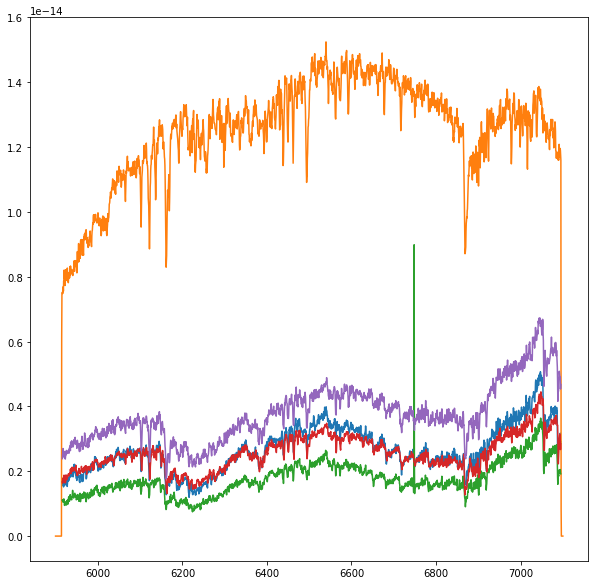

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))

for name in names:
    plt.plot(coadded[name][0][0], coadded[name][0][1])
    
    hdr = fits.Header()
    hdr['RA'] = ms_coords[name][0]
    hdr['DEC'] = ms_coords[name][1]
    hdr['NAME'] = name
    
    hdu = fits.PrimaryHDU([coadded[name][0][0], coadded[name][0][1], coadded[name][0][2]], header = hdr)
    
    hdul = fits.HDUList([hdu])
    hdul.writeto('process_ms/' + name + '.fits', overwrite=True)

In [8]:
# Coadd red spectra

wd_fits = glob.glob('WD/CDAFB*.fits')
wd_dirs = glob.glob('WD/CDAFB*[!.fits]')

In [9]:
reds = []
blues = []

for file in wd_fits:
    if 'r' in file:
        reds.append(file)
    elif 'b' in file:
        blues.append(file)
        
for dirs in wd_dirs:
    wd_dir_files = (glob.glob(dirs + '/*'))
    
    for file in wd_dir_files:
        if 'r' in file:
            reds.append(file)
        elif 'b' in file:
            blues.append(file)

In [10]:
blues

['WD/CDAFB_WD1931p2109.0032b.0002.fits',
 'WD/CDAFB_WD1931p2109.0031b.0001.fits',
 'WD/CDAFB_WD1931p2109.0032b.0001.fits',
 'WD/CDAFB_WD1931p2109.0031b.0002.fits',
 'WD/CDAFB_WD1928m1252.0038.0001/CDAFB_WD1928m1252.0038b.0001.fits',
 'WD/CDAFB_WDcc1847p1811.0018.0001/CDAFB_WDcc1847p1811.0018b.0001.fits',
 'WD/CDAFB_WDcc1847p1811.0019.0001/CDAFB_WDcc1847p1811.0019b.0001.fits',
 'WD/CDAFB_WD1847p1811.0027.0001/CDAFB_WD1847p1811.0027b.0001.fits',
 'WD/CDAFB_WDcc1847p1811.0020.0001/CDAFB_WDcc1847p1811.0020b.0001.fits',
 'WD/CDAFB_WD1847p1811.0023.0001/CDAFB_WD1847p1811.0023b.0001.fits',
 'WD/CDAFB_WD1928m1252.0037.0001/CDAFB_WD1928m1252.0037b.0001.fits',
 'WD/CDAFB_WD1847p1811.0025.0001/CDAFB_WD1847p1811.0025b.0001.fits',
 'WD/CDAFB_WDcc1847p1811.0017.0001/CDAFB_WDcc1847p1811.0017b.0001.fits',
 'WD/CDAFB_WD1847p1811.0024.0001/CDAFB_WD1847p1811.0024b.0001.fits',
 'WD/CDAFB_WD_1847p1811.0022.0001/CDAFB_WD1847p1811.0022b.0001.fits']

In [11]:
names = []

for file in blues:
    temp = fits.open(file)
    names.append(temp[0].header['OBJNAME'])
names = list(set(names))

In [12]:
targets = {}
blue_coords = {}

for name in names:
    targets[name] = []
    
for name in names:
    for file in tqdm(blues):
        temp = fits.open(file)
        
        if temp[0].header['OBJNAME'] == name:
            blue_coords[name] = (temp[0].header['RA'], temp[0].header['DEC'])
            targets[name].append(temp[0])

100%|██████████| 15/15 [00:00<00:00, 783.96it/s]


In [13]:
print(targets.keys())

dict_keys(['WD1931+2109', 'WD1847+1811', 'WD1928-1252'])


In [14]:
blue_coadded = {}
for name in names:
    blue_coadded[name] = []

for name in targets.keys():
    wl, fl, ivar = spectrum_coadd(targets[name])
    
    blue_coadded[name].append([wl, fl, ivar])

<ipython-input-2-227c8e26f0ba>:11: RuntimeWarning: divide by zero encountered in power
  ivar = exp.data[3,0,:]**-2
<ipython-input-2-227c8e26f0ba>:24: RuntimeWarning: divide by zero encountered in true_divide
  ivar = 1 / variance


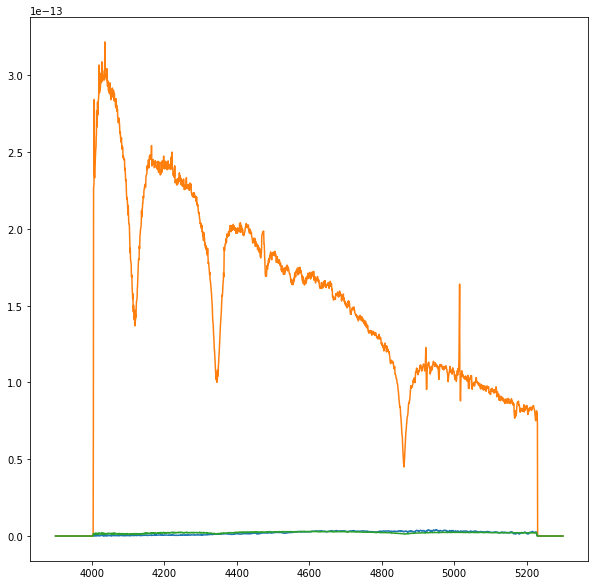

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))

for name in names:
    plt.plot(blue_coadded[name][0][0], blue_coadded[name][0][1])
    table = Table()
    table['flux'] = blue_coadded[name][0][0]
    table['wl'] = blue_coadded[name][0][1]
    table['ivar'] = blue_coadded[name][0][2]
    
    #table.write('process_wd/' + name + '.fits', overwrite=True)

In [16]:
names = []

for file in reds:
    temp = fits.open(file)
    names.append(temp[0].header['OBJNAME'])
names = list(set(names))

In [17]:
targets = {}
red_coords = {}

for name in names:
    targets[name] = []
    
for name in names:
    for file in tqdm(reds):
        temp = fits.open(file)
        
        if temp[0].header['OBJNAME'] == name:
            red_coords[name] = (temp[0].header['RA'], temp[0].header['DEC'])
            targets[name].append(temp[0])

100%|██████████| 14/14 [00:00<00:00, 715.09it/s]


In [18]:
targets.keys()

dict_keys(['WD1847+1811', 'WD0650+3754', 'WD1928-1252'])

In [19]:
red_coadded = {}
for name in names:
    red_coadded[name] = []

for name in targets.keys():
    wl, fl, ivar = spectrum_coadd(targets[name])
    
    red_coadded[name].append([wl, fl, ivar])

<ipython-input-2-227c8e26f0ba>:11: RuntimeWarning: divide by zero encountered in power
  ivar = exp.data[3,0,:]**-2
<ipython-input-2-227c8e26f0ba>:24: RuntimeWarning: divide by zero encountered in true_divide
  ivar = 1 / variance


[5900.   5900.58 5901.16 ... 7098.86 7099.44 7100.02]


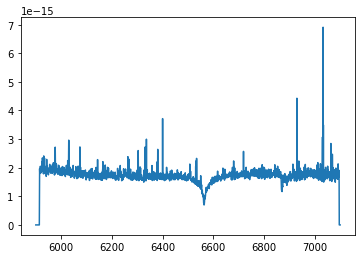

In [20]:
import matplotlib.pyplot as plt

print(red_coadded['WD1847+1811'][0][0])

plt.plot(red_coadded['WD1847+1811'][0][0], red_coadded['WD1847+1811'][0][1])

#plt.figure(figsize = (10,10))
#
#for name in names:
#    print(name)
#    plt.plot(red_coadded[name][0][0], red_coadded[name][0][1])

In [21]:
print(blue_coadded.keys())
print(red_coadded.keys())
print(red_coadded['WD1928-1252'][0][0])

dict_keys(['WD1931+2109', 'WD1847+1811', 'WD1928-1252'])
dict_keys(['WD1847+1811', 'WD0650+3754', 'WD1928-1252'])
[5900.   5900.58 5901.16 ... 7098.86 7099.44 7100.02]


In [22]:
wd_spectra = {}
wd_coords = {}
wd_lines = {}

for name in blue_coadded.keys():
    wd_coords[name] = blue_coords[name]
    
    try:
        wl = np.concatenate((blue_coadded[name][0][0], red_coadded[name][0][0]))
        fl = np.concatenate((blue_coadded[name][0][1], red_coadded[name][0][1]))
        ivar = np.concatenate((blue_coadded[name][0][2], red_coadded[name][0][2]))
                
        wd_lines[name] = ['a', 'b', 'g']
    except:
        wl = blue_coadded[name][0][0]
        fl = blue_coadded[name][0][1]
        ivar = blue_coadded[name][0][2]
                
        wd_lines[name] = ['b', 'g']
        
    wd_spectra[name] = np.array([wl, fl, ivar])
        
for name in red_coadded.keys():
    if name not in wd_spectra.keys():
        wl = red_coadded[name][0][0]
        fl = red_coadded[name][0][1]
        ivar = red_coadded[name][0][2]
        
        wd_lines[name] = ['a']
        
        wd_spectra[name] = np.array([wl, fl, ivar])
        wd_coords[name] = red_coords[name]

In [23]:
wd_coords['WD1928-1252'][1]

'-12:52:00.97'

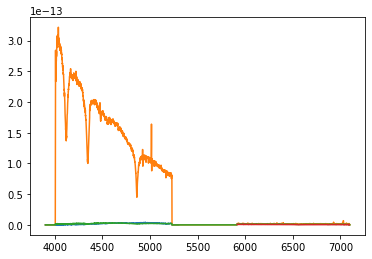

In [24]:
for name in wd_spectra.keys():
    plt.plot(wd_spectra[name][0], wd_spectra[name][1])

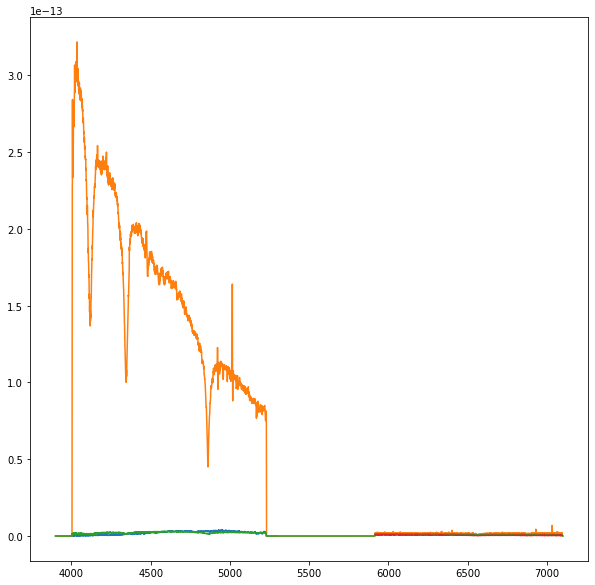

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))

for name in wd_spectra.keys():
    plt.plot(wd_spectra[name][0], wd_spectra[name][1])
    
    hdr = fits.Header()
    hdr['RA'] = wd_coords[name][0]
    hdr['DEC'] = wd_coords[name][1]
    hdr['LINES'] = ''.join(wd_lines[name])
    hdr['NAME'] = name
    
    hdu = fits.PrimaryHDU([wd_spectra[name][0], wd_spectra[name][1], wd_spectra[name][2]], header = hdr)
    
    hdul = fits.HDUList([hdu])
    hdul.writeto('process_wd/' + name + '.fits', overwrite=True)